# Position voronoi in cartesian coordinates

In [1]:
import sys
import os
from time import time

try:
    os.chdir(r"/home/hanaz63/2024_molgri2/nobackup/molecularRotationalGrids")
    sys.path.append(r"/home/hanaz63/2024_molgri2/nobackup/molecularRotationalGrids")
except FileNotFoundError:
    os.chdir(r"D:\\HANA\\phD\\PAPER_2022\\molecularRotationalGrids")
    sys.path.append(r"D:\\HANA\\phD\\PAPER_2022\\molecularRotationalGrids")

In [2]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


from molgri.space.fullgrid import FullGrid
from molgri.space.voronoi import PositionVoronoi
from molgri.space.utils import sort_points_on_sphere_ccw

import numpy as np
from numpy.typing import NDArray
import plotly.graph_objects as go
import plotly.io as pio
from plotly.colors import DEFAULT_PLOTLY_COLORS
import plotly.express as px
from scipy.spatial import Voronoi, ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")


rng = np.random.default_rng(11)

In [3]:
%matplotlib widget

## Visualization

First step: throwing a Voronoi tessellation algorithm directly on the position grid and seeing what happens.

In [4]:
ex_position_grid = FullGrid("3", "17", "[0.2, 0.4, 0.6]").get_position_grid()
ex_position_grid2 = FullGrid("3", "17", "[0.2, 0.4, 0.6, 0.8]").get_position_grid()
position_grid_points = ex_position_grid.get_position_grid_as_array()

# all the old properties
position_voronoi = PositionVoronoi(ex_position_grid.o_positions, point_radii=ex_position_grid.get_radii())
position_voronoi_vertices = position_voronoi.get_all_voronoi_vertices()

old_volumes = ex_position_grid.get_all_position_volumes()
old_adjacency = ex_position_grid.get_adjacency_of_position_grid()
old_distances = ex_position_grid.get_distances_of_position_grid()
old_surfaces = ex_position_grid.get_borders_of_position_grid()

Warning! For <=4 points, volumes, areas etc are only estimated.
Warning! For <=4 points, volumes, areas etc are only estimated.


In [5]:
# new voronoi (not spherical)
normal_voronoi = Voronoi(ex_position_grid2.get_position_grid_as_array())
normal_voronoi_vertices = normal_voronoi.vertices

Plotting grid points (black), old (pink) and new (blue) Voronoi vertices.

Immediately obvious: same direction rays, different radii.

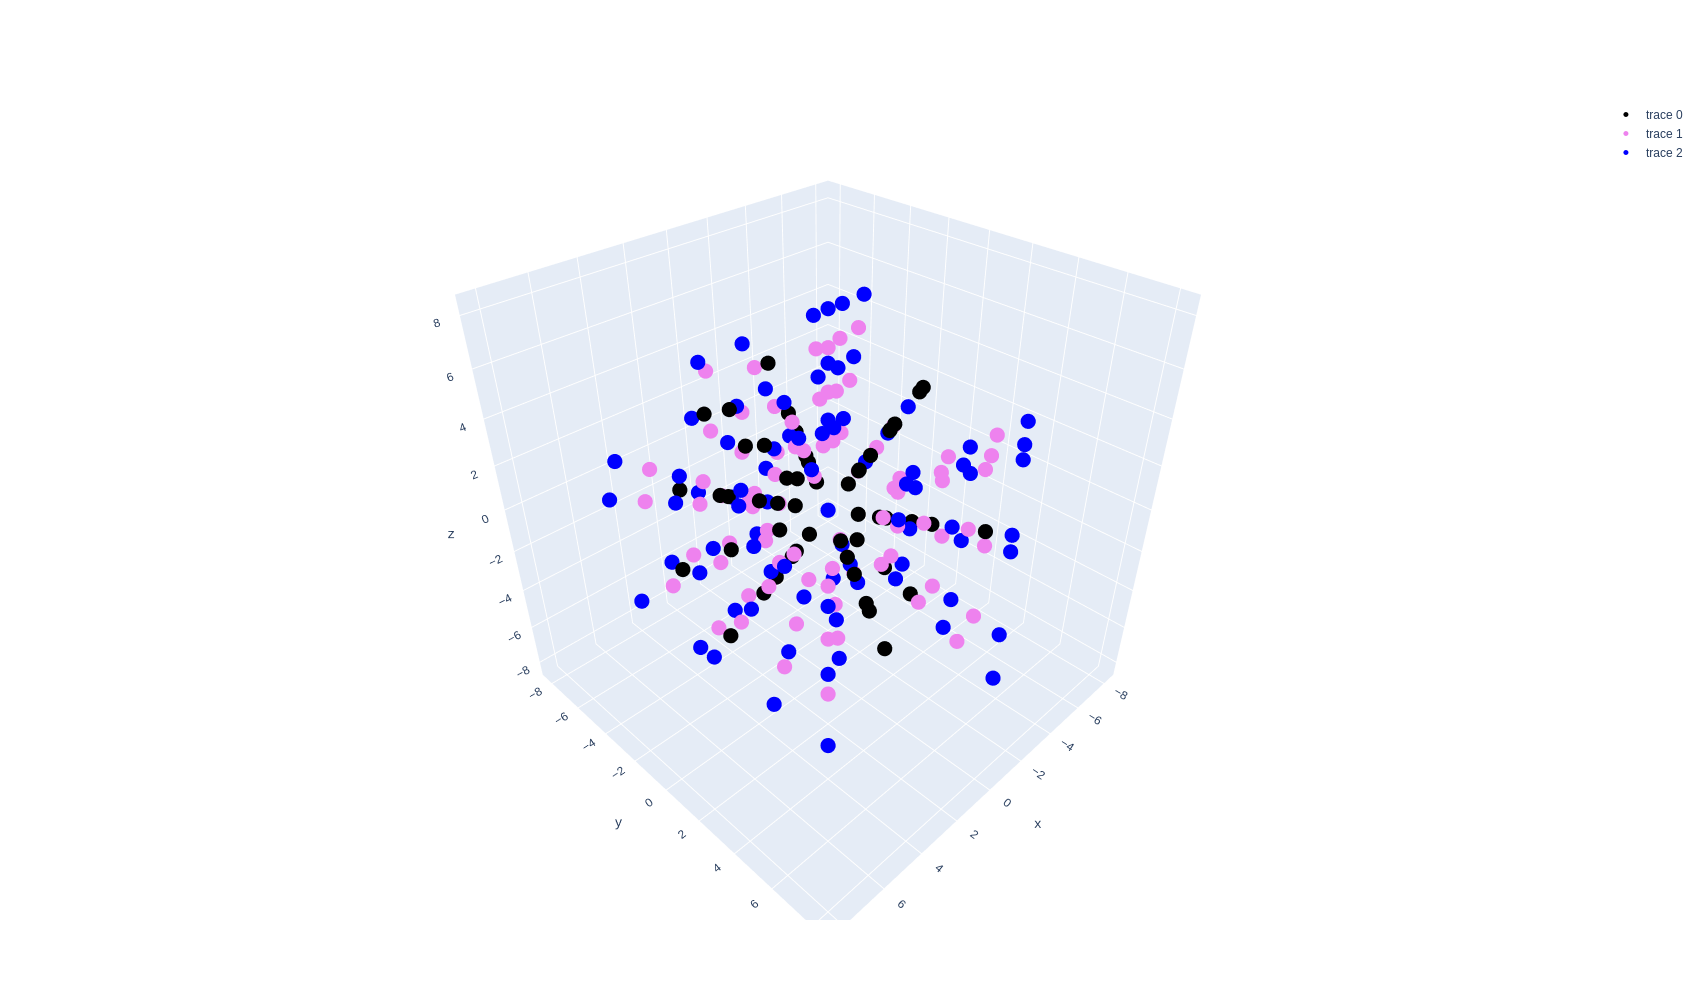

In [226]:
# plot the grid points in black
scatter1 = go.Scatter3d(x=position_grid_points.T[0], y=position_grid_points.T[1], z=position_grid_points.T[2],
            mode='markers', marker=dict(size=5, color='black', opacity=1))
# plot the old voronoi vertices in violet
scatter2 = go.Scatter3d(x=position_voronoi_vertices.T[0], y=position_voronoi_vertices.T[1], z=position_voronoi_vertices.T[2],
            mode='markers', marker=dict(size=5, color='violet', opacity=1))
# plot new cartesian voronoi in blue
scatter3 = go.Scatter3d(x=normal_voronoi_vertices.T[0], y=normal_voronoi_vertices.T[1],
                        z=normal_voronoi_vertices.T[2],
            mode='markers', marker=dict(size=5, color='blue', opacity=1))


fig = go.Figure(data=[scatter1, scatter2, scatter3])
fig.update_layout(autosize=False, width=1000, height=1000)
fig.show()


If we plot just one cell the form of a frustum is also visible.

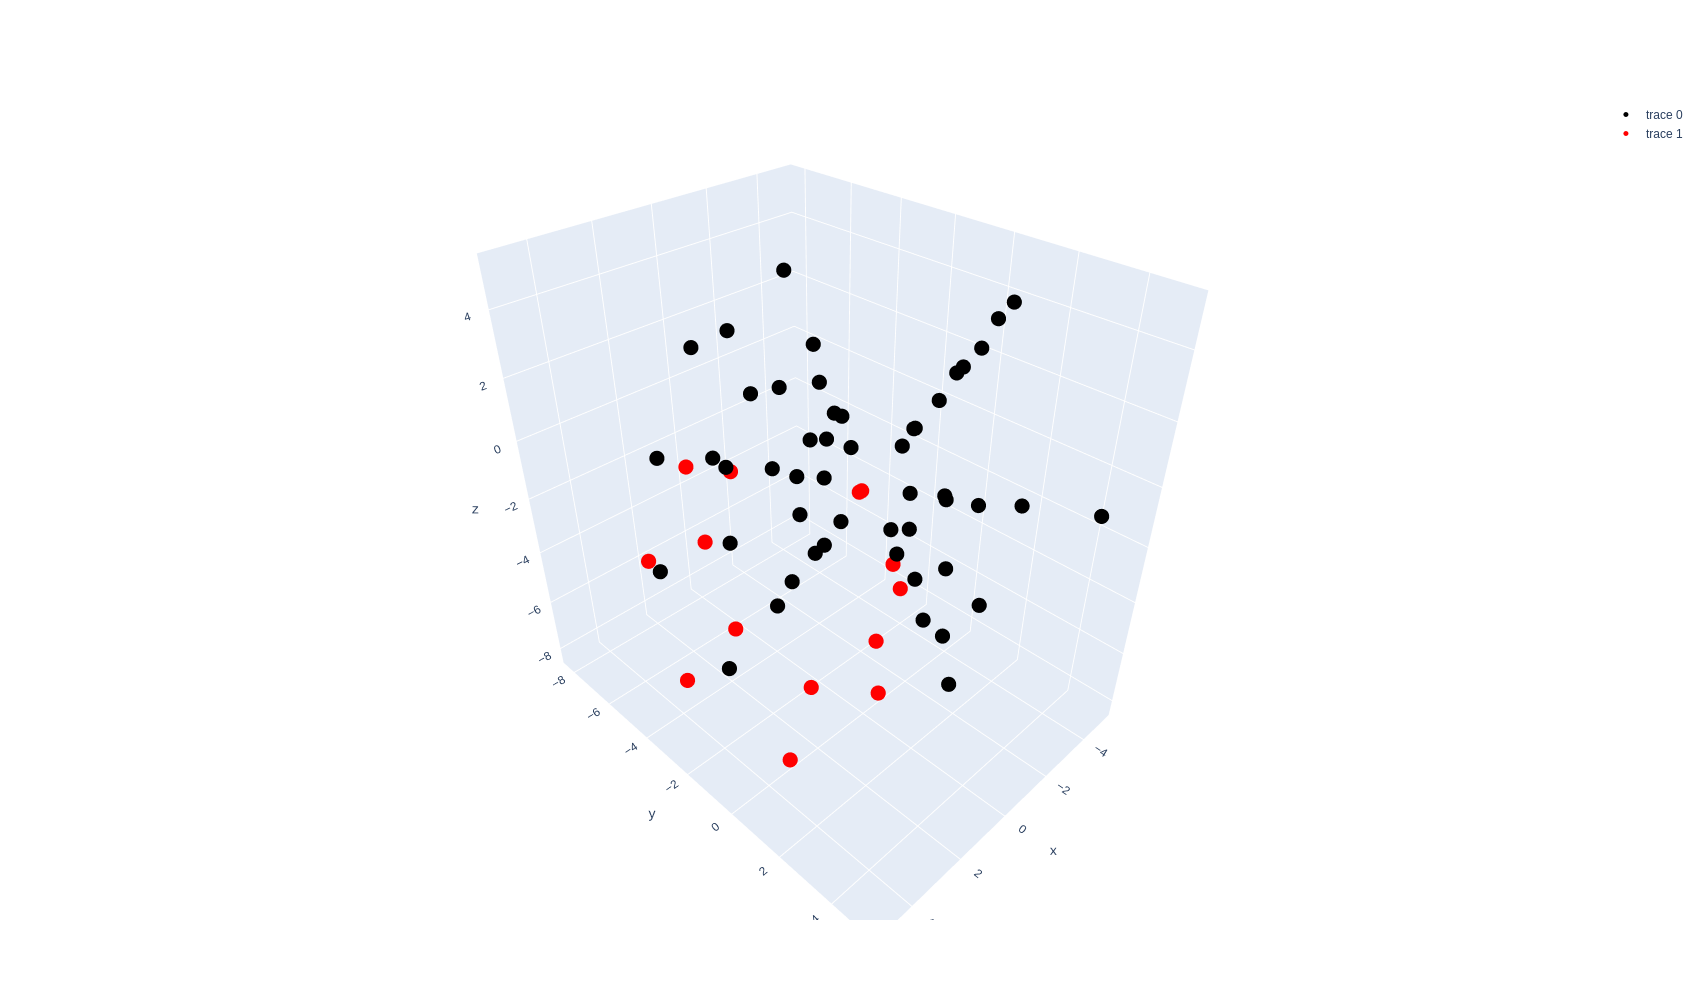

In [227]:
# plot just the region of one particular point
point_region = normal_voronoi.regions[7]
point_region_vertices = normal_voronoi_vertices[point_region]
scatter4 =  go.Scatter3d(x=point_region_vertices.T[0], y=point_region_vertices.T[1],
                        z=point_region_vertices.T[2],
            mode='markers', marker=dict(size=5, color='blue', opacity=1))
fig = go.Figure(data=[scatter1, scatter4])
fig.update_layout(autosize=False, width=1000, height=1000)
fig.show()

For even better visualization we plot the polygons.

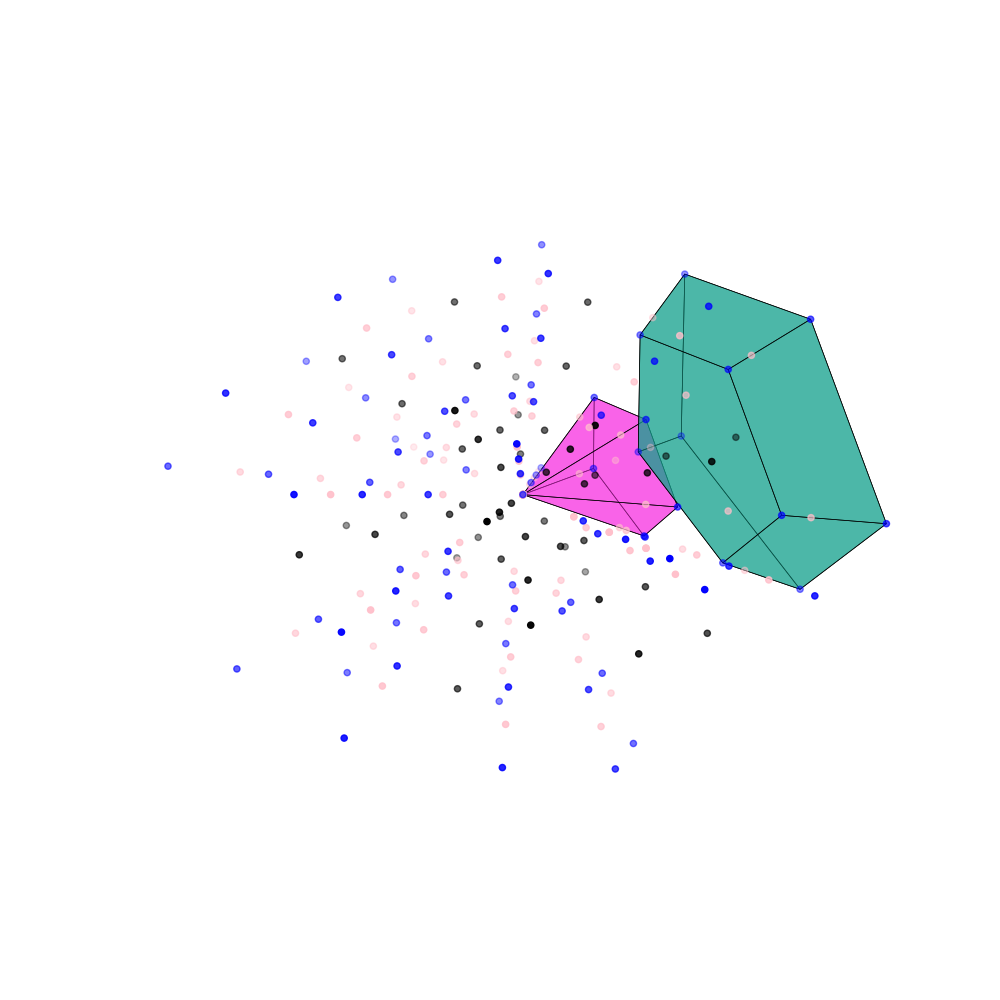

In [244]:
polygons = []
for ri, region in enumerate(normal_voronoi.regions):
    # only plot those polygons for which all vertices are defined
    if np.all(np.asarray(region) >= 0) and len(region) > 0:
        poly = []
        for rv in normal_voronoi.ridge_vertices:
            if np.isin(rv, region).all():
                poly.append(normal_voronoi.vertices[rv])
        polygons.append(poly)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# only plot two
polygons = [polygons[10],polygons[32], ] #polygons[7],
#polygons[11], polygons[12], polygons[13], polygons[16],polygons[14]
# polygons[13], polygons[15], polygons[16], polygons[17], polygons[18], polygons[19]
# polygons[16],polygons[10], polygons[11], polygons[12], polygons[13], polygons[14]
# polygons[19],, polygons[1], polygons[0], polygons[2], polygons[3], polygons[4]

# now cycle thorugh all available polygons
for poly in polygons:
    polygon = Poly3DCollection(poly, alpha=0.5,
                               facecolors=rng.uniform(0, 1, 3),
                               linewidths=0.5, edgecolors='black')
    ax.add_collection3d(polygon)

# simply setting the plot limits doesn't help
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
ax.set_zlim([-6, 6])


ax.scatter(*position_grid_points.T, color="black", s=20)
ax.scatter(*position_voronoi_vertices.T, color="pink", s=20)
ax.scatter(*normal_voronoi_vertices.T, color="blue", s=20)
ax.set_axis_off()
plt.show()


## Volumes

New volumes shown in black, old in red.

Scipy can get the volume simply from the convex hull.

Normal voronoi volumes [  9.46283011  11.43276733  11.96046107  12.48815481   8.93513636
   6.4375054    6.96519914  11.43276733   9.46283011   9.46283011
   8.93513636   9.46283011   5.70183985   4.80407363   5.70183985
   5.70183985   4.80407363  34.34656854  41.49671104  43.41204389
  45.32737673  32.43123569  23.36576034  25.28109319  41.49671104
  34.34656854  34.34656854  32.43123569  34.34656854  20.69556687
  17.437008    20.69556687  20.69556687  17.437008    76.40359124
  92.30901027  96.56964864 100.83028702  72.14295286  51.97689546
  56.23753384  92.30901027  76.40359124  76.40359124  72.14295286
  76.40359124  46.03707732  38.78844637  46.03707732  46.03707732
  38.78844637]
spherical voronoi volumes [11.05091834 12.15530051 12.48127547 12.78107321 10.72100013  9.34066293
  9.23538742 12.14772002 11.07911293 11.063094   10.72030673 11.04393914
  8.91727624  8.17254852  8.88883371  8.87526907  8.15389442 27.00318902
 30.16147329 31.09007613 31.94596448 26.08194288 22.13560

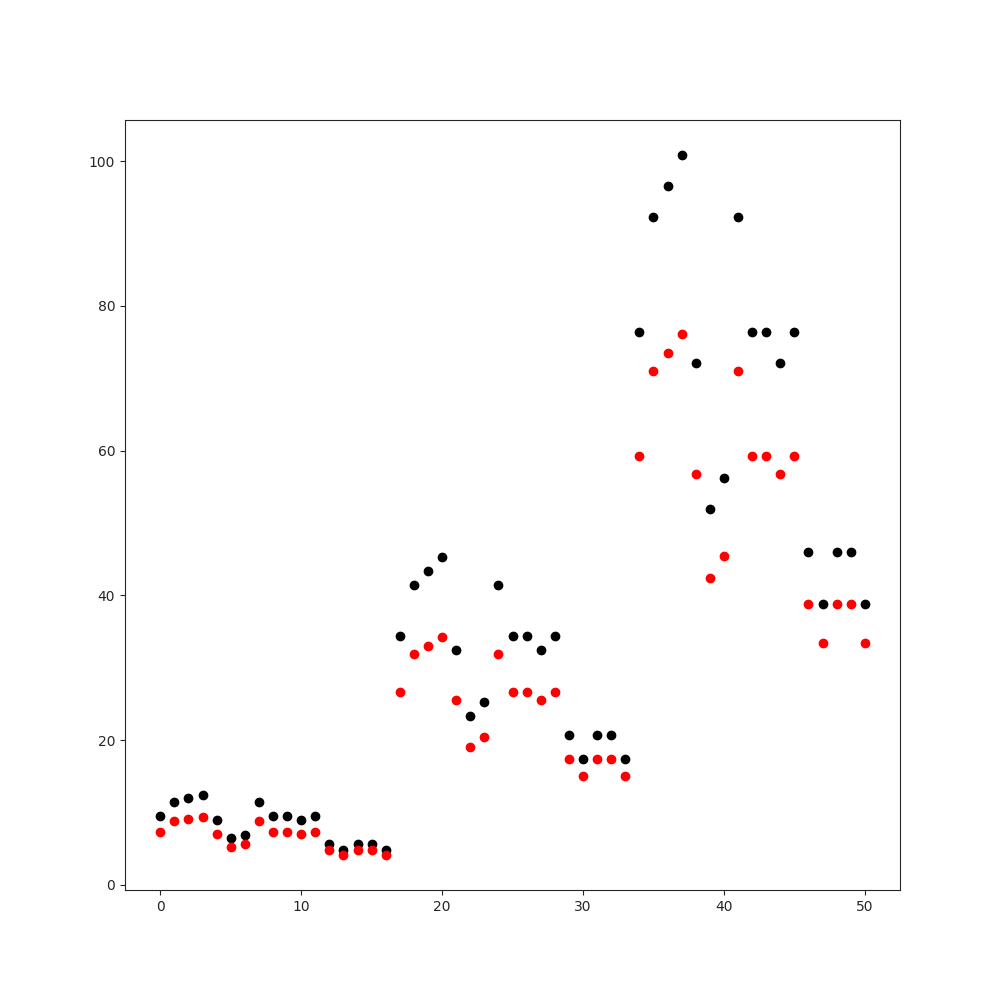

In [9]:
new_volumes = np.zeros(len(position_grid_points))
for idx, i_region in enumerate(normal_voronoi.point_region):
    # Open cells are removed from the calculation of the total volume
    if -1 not in normal_voronoi.regions[i_region]:
        new_volumes[idx] = ConvexHull(normal_voronoi.vertices[normal_voronoi.regions[i_region]]).volume
print("Normal voronoi volumes", new_volumes)
print("spherical voronoi volumes", position_voronoi.get_voronoi_volumes())

fig = plt.figure( figsize=(10,10))
ax = fig.add_subplot(111)
x = np.arange(len(position_grid_points))
ax.scatter(x, new_volumes, color="black")
ax.scatter(x, old_volumes, color="red")

plt.show()

## Distances

Take the old adjacency matrix of the position grid and for each pair of neighbours calculate the Euclidean distance.

Old distances (array([1.10715, 1.25664, 2.     , 2.03444, 2.2143 , 2.51327, 3.32145,
       3.76991, 4.06889, 4.42859, 6.10333, 6.64289]), array([20,  2, 68, 16, 70,  2, 20,  2, 16, 50, 16, 50]))
New distances (array([1.09307, 1.23607, 1.94786, 2.     , 2.10292, 2.18613, 2.47214,
       3.2792 , 3.7082 , 3.89572, 4.20585, 5.84357, 6.30877]), array([20,  2, 16, 68, 50, 20,  2, 20,  2, 16, 50, 16, 50]))
Number of adjacent cells: 332, num old distances: 332, num new distances: 332


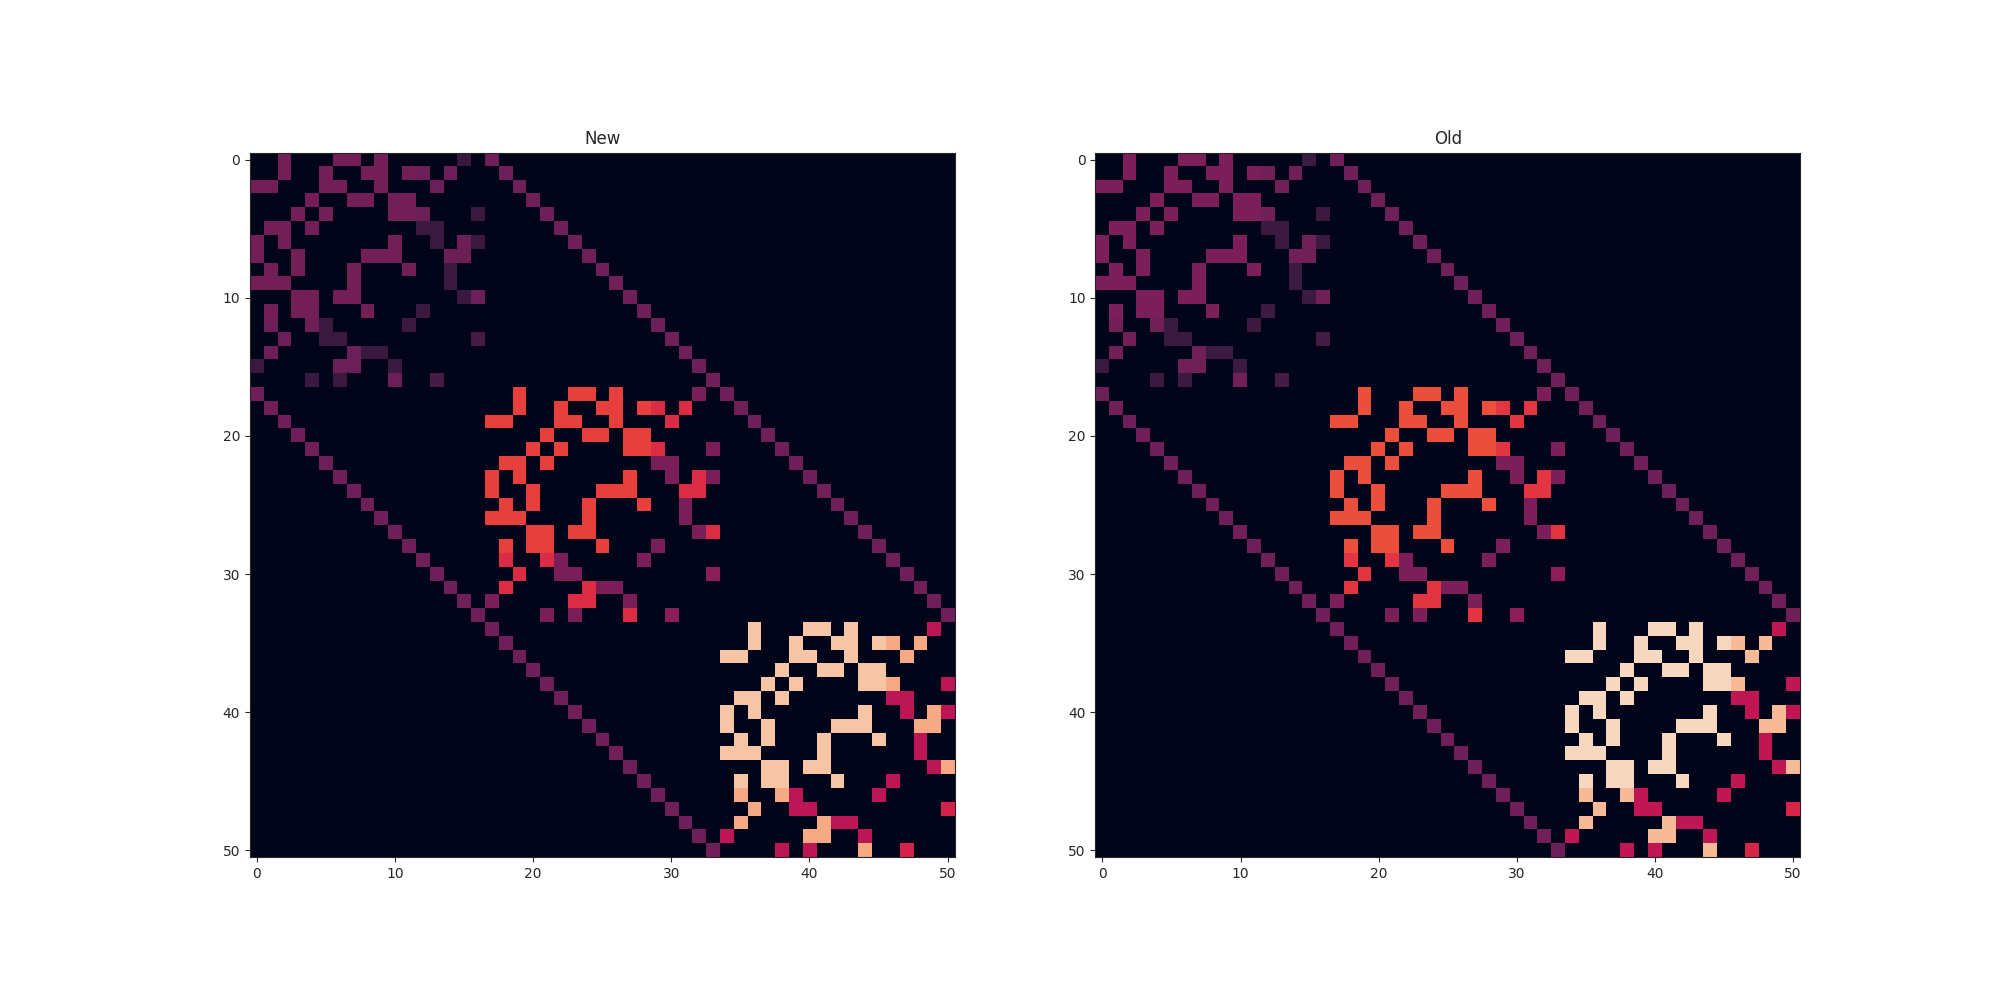

In [10]:
new_h_matrix = old_adjacency.tocoo()
new_data = []
for row, col in zip(new_h_matrix.row, new_h_matrix.col):
    new_data.append(np.linalg.norm(position_grid_points[row]-position_grid_points[col]))
new_h_matrix.data = np.array(new_data)

print("Old distances", np.unique(np.round(old_distances.data, 5), return_counts=True))
print("New distances", np.unique(np.round(new_h_matrix.data, 5), return_counts=True))

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(new_h_matrix.toarray(), vmin=0, vmax=7)
ax[0].set_title("New")
ax[1].imshow(old_distances.toarray(), vmin=0, vmax=7)
ax[1].set_title("Old")
plt.show()

## Surfaces

Surfaces are most tricky. The algorithm goes as follows:
- for neighbours (1 in the adjacency matrix), determine which Voronoi vertices they share
- these vertices form a polygon in 3D space
- we must sort the vertices of this polygon - for that we calculate the center and the angles between center-first point and center-other points. To give this angle a sign, we decide on a normal vector and then look at the sign of the dot product between the normal vector and the cross product of the two vectors creating an angle
- now we are ready to calculate the area by summing the areas of triangles

In [67]:
def get_coordinates_of_border_polygons(adjaceny_matrix_coo):
    """
    These are 3d coordinates and not yet sorted. A list must be returned as the dimension is different every time.
    """
    new_S_matrix = old_adjacency.tocoo()
    all_polygons_3d = []
    ind = 0
    for row, col in zip(new_S_matrix.row, new_S_matrix.col):
        row_region = normal_voronoi.point_region[row]
        indices_row_regions = normal_voronoi.regions[row_region]
        #vertices_row = normal_voronoi.vertices[indices_row_regions]
        col_region = normal_voronoi.point_region[col]
        #vertices_col = normal_voronoi.vertices[normal_voronoi.regions[col_region]]
        indices_col_regions = normal_voronoi.regions[col_region]
        shared_vertices = set(indices_row_regions).intersection(set(indices_col_regions))
        print(f"{ind}: Shared points: {shared_vertices}")
        all_polygons_3d.append(np.array([x for i, x in enumerate(normal_voronoi.vertices) if i in shared_vertices]))
        ind+=1
    return all_polygons_3d
    

all_polygons_3d  = get_coordinates_of_border_polygons(old_adjacency.tocoo())

0: Shared points: {75, 85, 69}
1: Shared points: {75, 76, 85}
2: Shared points: {81, 82, 85}
3: Shared points: {82, 85, 69}
4: Shared points: {81, 76, 85}
5: Shared points: {69, 75, 76, 81, 82}
6: Shared points: {85, 21, 7}
7: Shared points: {85, 21, 39}
8: Shared points: {9, 26, 85}
9: Shared points: {10, 85, 7}
10: Shared points: {40, 26, 85}
11: Shared points: {40, 85, 39}
12: Shared points: {9, 10, 85}
13: Shared points: {39, 40, 9, 10, 7, 21, 26}
14: Shared points: {75, 85, 69}
15: Shared points: {85, 21, 7}
16: Shared points: {85, 20, 21}
17: Shared points: {74, 75, 85}
18: Shared points: {85, 69, 7}
19: Shared points: {74, 20, 85}
20: Shared points: {69, 7, 74, 75, 20, 21}
21: Shared points: {66, 27, 85}
22: Shared points: {83, 85, 86}
23: Shared points: {83, 28, 85}
24: Shared points: {66, 85, 86}
25: Shared points: {27, 28, 85}
26: Shared points: {66, 83, 86, 27, 28}
27: Shared points: {66, 27, 85}
28: Shared points: {41, 59, 85}
29: Shared points: {66, 67, 85}
30: Shared poin

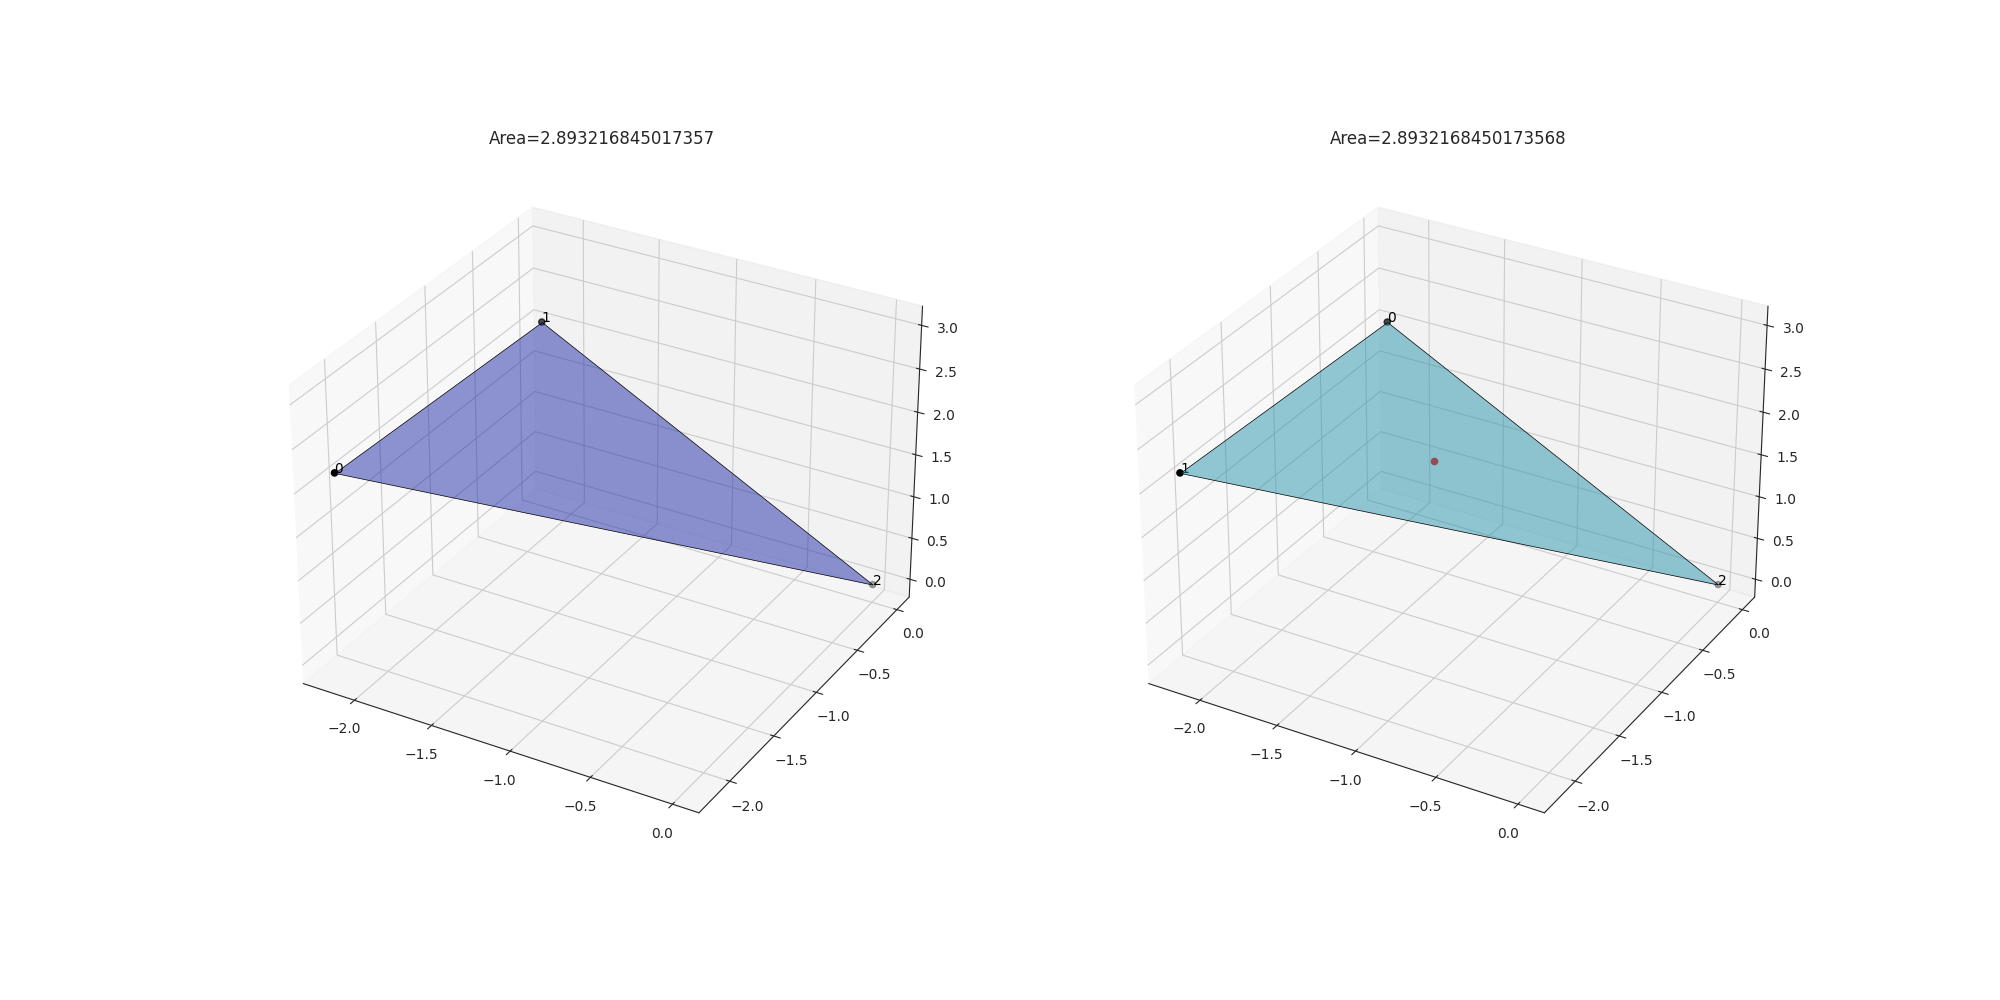

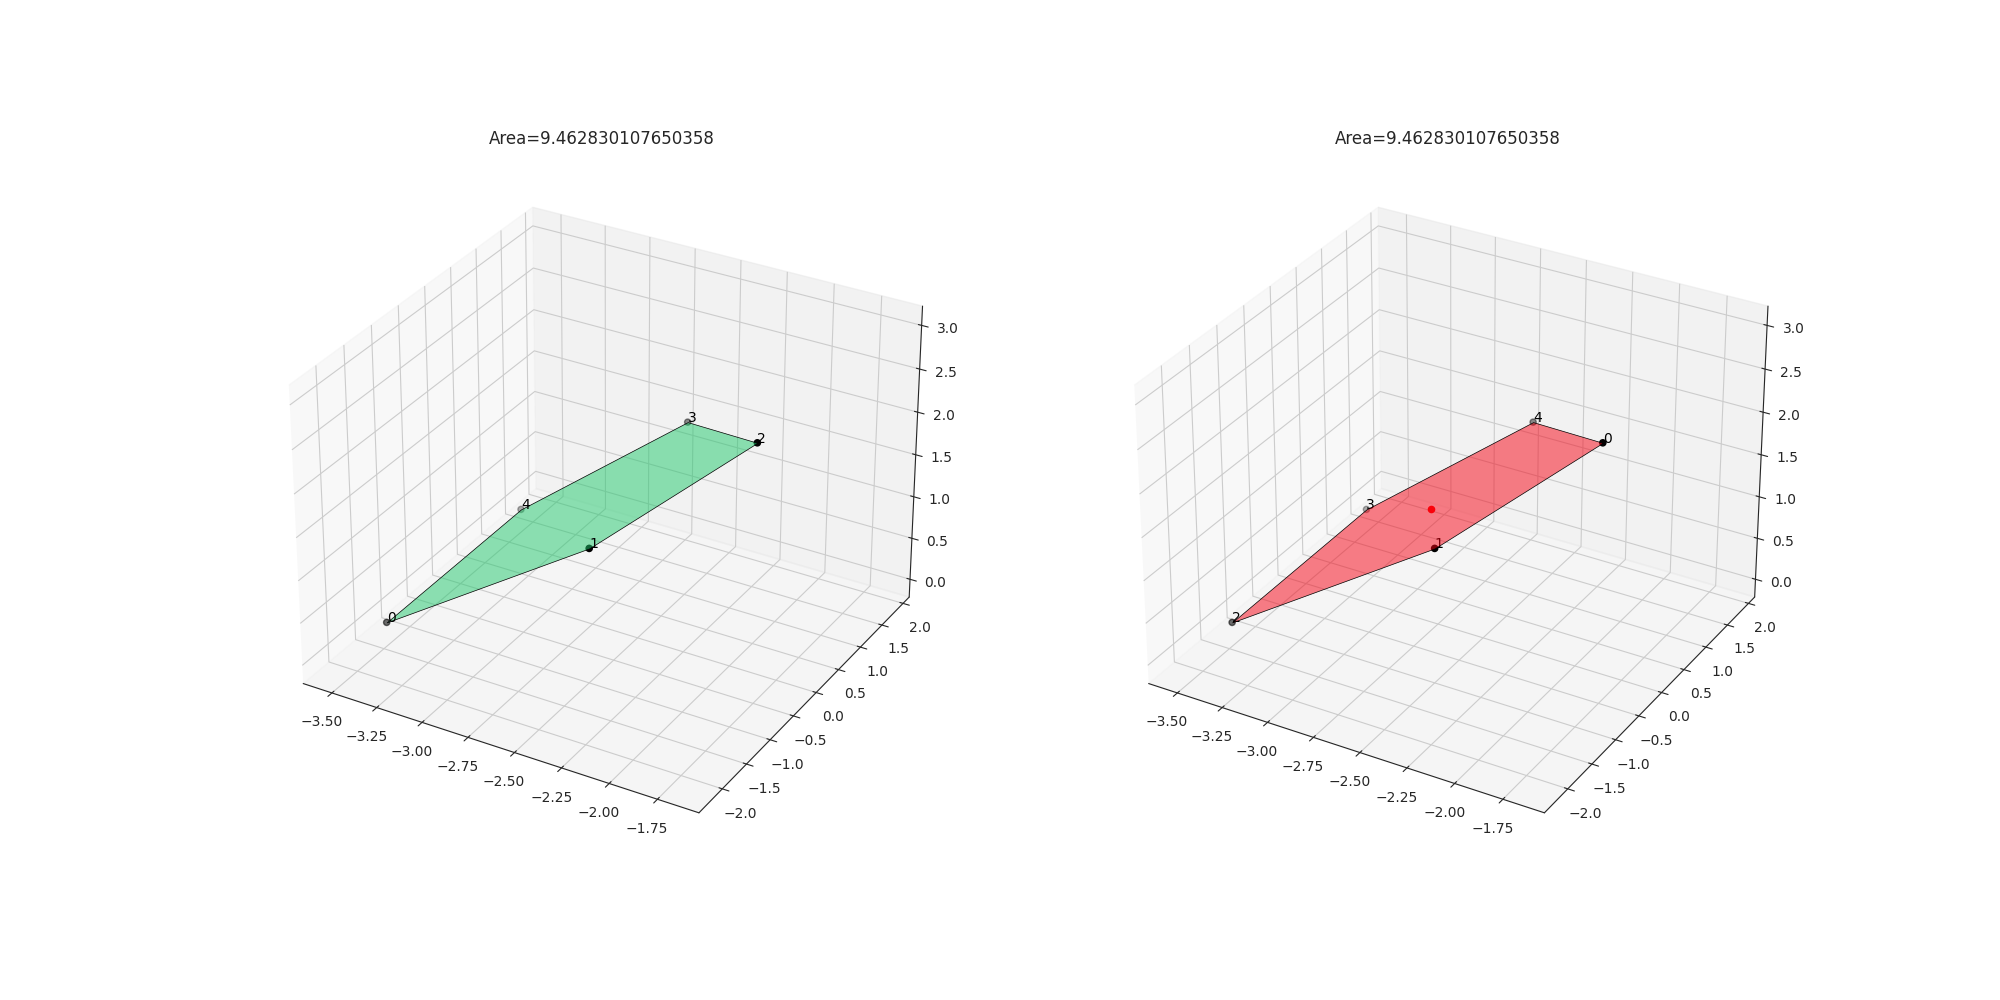

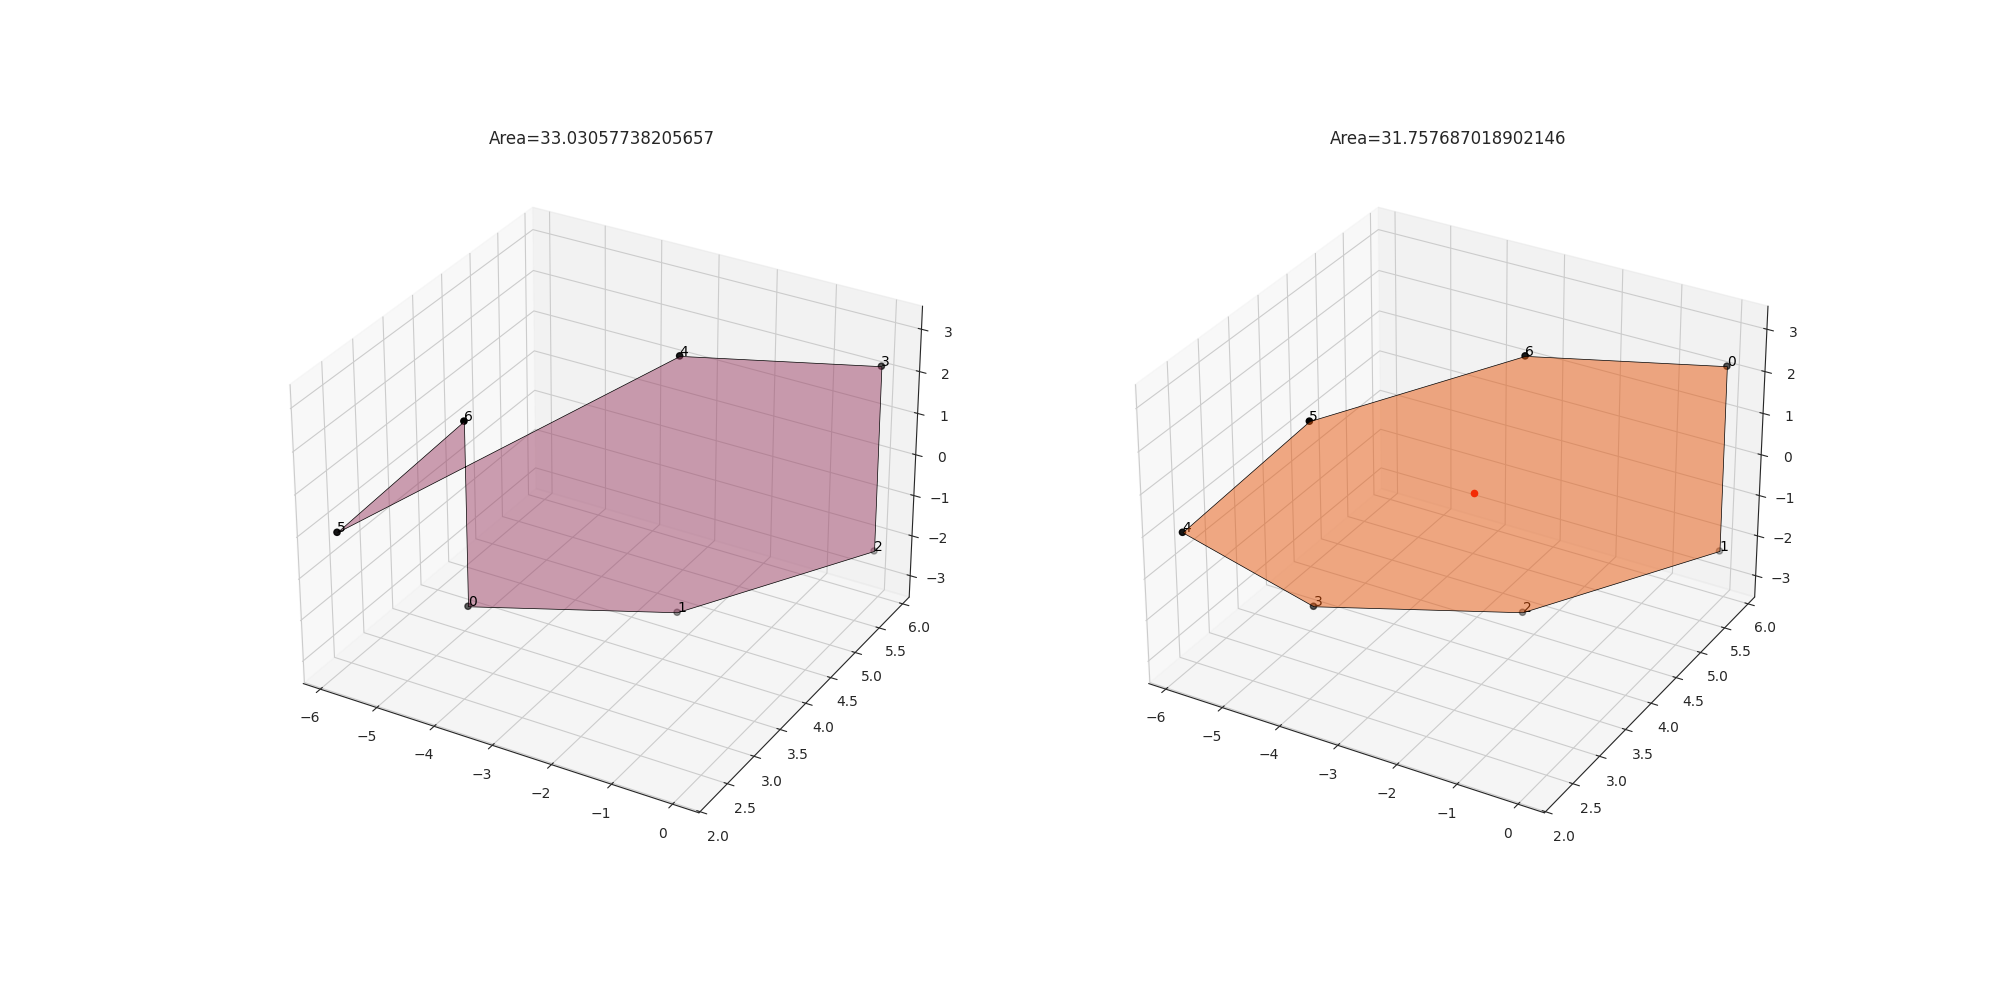

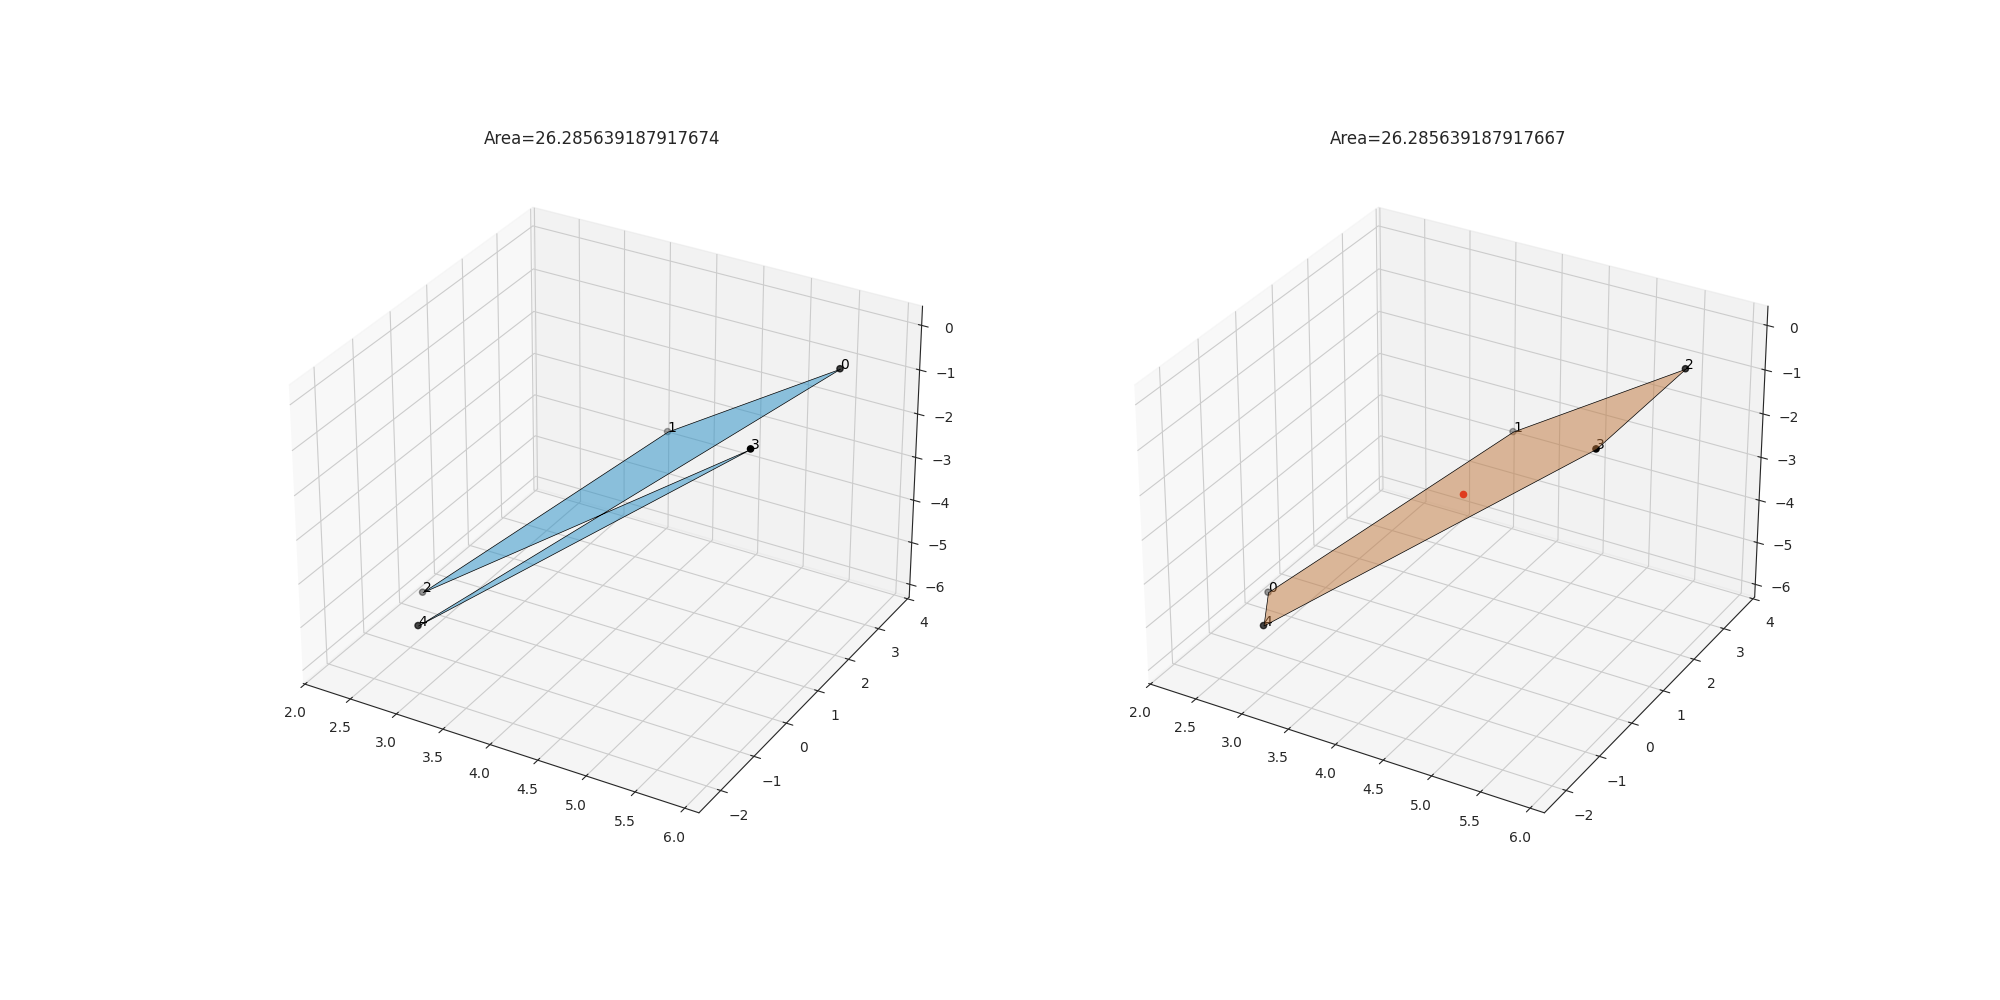

In [245]:

import math

def order_points(polygon_points_3d: NDArray):
    """
    Each row should be a point.
    """
    first_point = polygon_points_3d[0]
    different_point = polygon_points_3d[1]
    center = np.mean(polygon_points_3d,axis=0)
    normal_vector = np.cross(first_point-center, different_point-center)
    alphas= [0]
    for point in polygon_points_3d[1:]:
        A = (point-center)
        B = (first_point-center)
        C = np.cross(A, B)
        direction = np.sign(C.dot(normal_vector))
        alphas.append(direction*np.arccos(np.round(np.dot(A, B)/np.linalg.norm(A)/np.linalg.norm(B), 5)))
    order = np.argsort(alphas)
    return np.array([polygon_points_3d[i] for i in order])


def get_area(ordered_polygon_points_2d: NDArray):
    all_triangle_areas = 0
    n = len(ordered_polygon_points_2d)
    for k in range(1, n-1):
        all_triangle_areas += 0.5*np.abs(np.linalg.norm(np.cross(ordered_polygon_points_2d[0]-ordered_polygon_points_2d[k], ordered_polygon_points_2d[k+1]-ordered_polygon_points_2d[k])))
    return all_triangle_areas

for index_to_plot in [1, 5, 274, 301]: #330
    # 3d plot
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(*all_polygons_3d[index_to_plot].T, color="black")
    labels = np.arange(len(all_polygons_3d[index_to_plot]))
    for position, label in zip(all_polygons_3d[index_to_plot], labels):
        ax.text(*position, label, color="black")
    polygon = Poly3DCollection([all_polygons_3d[index_to_plot],], alpha=0.5,
                               facecolors=rng.uniform(0, 1, 3),
                               linewidths=0.5, edgecolors='black')
    ax.set_title(f"Area={get_area(all_polygons_3d[index_to_plot])}")
    ax.add_collection3d(polygon)
    
    # 3d plot ordered
    ax = fig.add_subplot(122, projection='3d')
    sorted_points = np.array(order_points(all_polygons_3d[index_to_plot]))
    ax.scatter(*sorted_points.T, color="black")
    ax.scatter(*np.mean(all_polygons_3d[index_to_plot], axis=0), color="red")
    labels = np.arange(len(sorted_points))
    for position, label in zip(sorted_points, labels):
        ax.text(*position, label, color="black")
    polygon = Poly3DCollection([sorted_points,], alpha=0.5,
                           facecolors=rng.uniform(0, 1, 3),
                           linewidths=0.5, edgecolors='black')
    ax.add_collection3d(polygon)
    ax.set_title(f"Area={get_area(sorted_points)}")
    plt.show()


Old surfaces (array([ 0.74768,  1.32922,  1.99382,  2.01573,  2.18888,  2.68405,
        3.0972 ,  3.28377,  3.58352,  3.89135,  4.14126,  4.43049,
        4.77164,  4.80481,  5.25345,  5.37528,  5.50614,  5.63034,
        5.83702,  5.83782,  7.02237,  7.15746,  7.33912,  7.87642,
        8.25921,  8.75673,  8.79129,  9.10803,  9.42478, 11.50349,
       11.81463, 13.3467 , 14.59292, 15.63982, 19.50659, 20.38643,
       24.42025, 25.3001 , 26.17994]), array([ 4,  4,  4, 26, 16,  2,  4, 20, 26, 16,  4, 16,  2,  6,  2, 26,  4,
        2, 16, 20,  4,  2,  8, 16,  4, 20,  4,  2,  2,  4, 16,  6,  2,  2,
        4,  8,  4,  2,  2]))
New surfaces (array([ 1.03566,  1.84117,  2.76175,  2.89322,  2.92724,  3.16027,
        3.57372,  4.75078,  4.80407,  5.1435 ,  5.20397,  5.21637,
        5.61826,  5.70184,  6.35327,  6.43751,  6.9652 ,  7.71524,
        7.80596,  8.42738,  8.44582,  8.93514,  9.27355,  9.46283,
        9.52991, 11.43277, 11.96046, 12.48815, 12.66874, 13.34465,
       13.91033, 

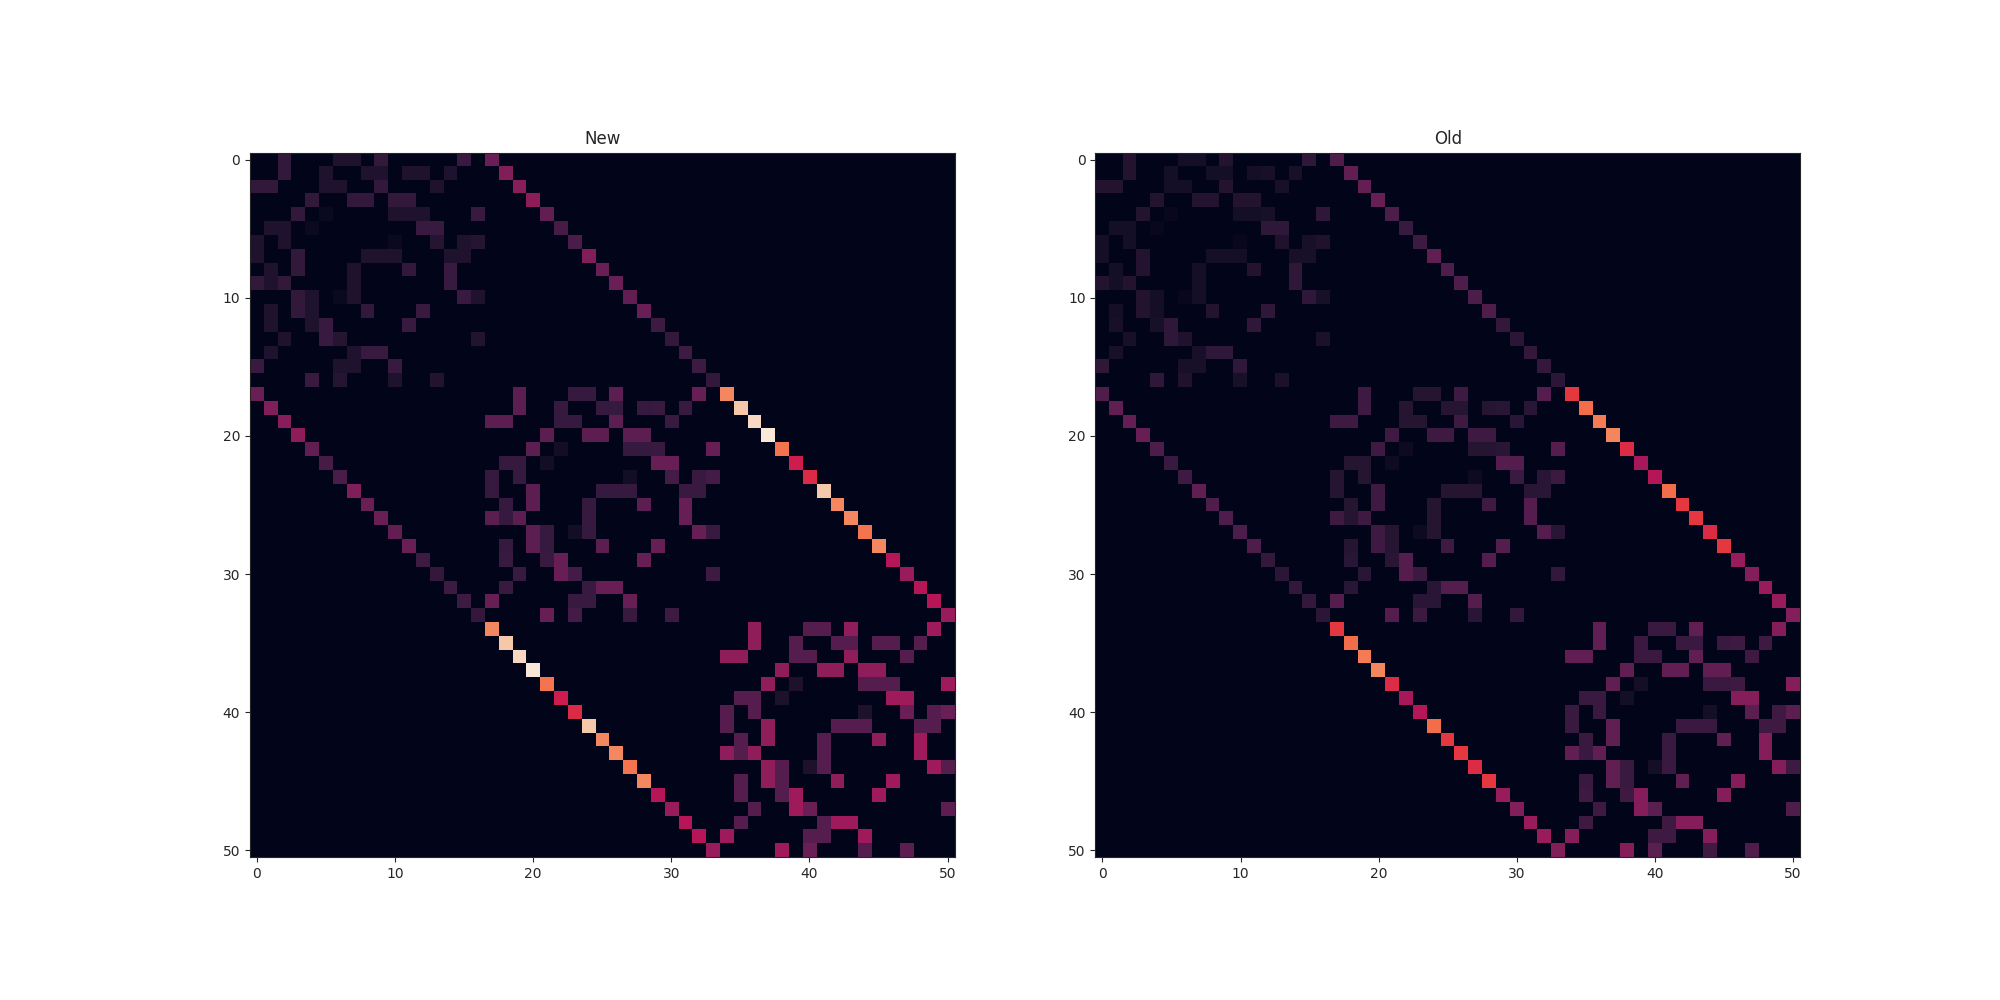

In [246]:
new_S_matrix = old_adjacency.tocoo()
all_areas = []
for el in all_polygons_3d:
    all_areas.append(get_area(order_points((el))))

new_S_matrix.data = np.array(all_areas)

print("Old surfaces", np.unique(np.round(old_surfaces.data, 5), return_counts=True))
print("New surfaces", np.unique(np.round(new_S_matrix.data, 5), return_counts=True))

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(new_S_matrix.toarray(), vmin=0, vmax=35)
ax[0].set_title("New")
ax[1].imshow(old_surfaces.toarray(), vmin=0, vmax=35)
ax[1].set_title("Old")
plt.show()
